In [575]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [576]:
def extract_date(df, date_col):
    df.copy(deep=True)
    df['hour'] = df[date_col].dt.hour
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['day'] = df[date_col].dt.dayofyear
    return df 

### PJM Historical Load Forecasts
From https://dataminer2.pjm.com/feed/load_frcstd_hist

In [577]:
# PJM Load Forecasts
pjm_df = pd.concat(map(pd.read_csv, ['load_forecasts/pjm/2016.csv', 'load_forecasts/pjm/2017.csv','load_forecasts/pjm/2018.csv']))
pjm_df = pjm_df.drop(['evaluated_at_utc', 'evaluated_at_ept', 'forecast_hour_beginning_ept'], axis = 1)
pjm_df.columns = ['Date', 'area', 'PJM']


In [578]:
# RTO columns represent the load forecast for all of PJM
pjm_df = pjm_df.loc[pjm_df['area'] == 'RTO']

In [579]:
# There are multiple forecasts provided per hour so take the first one 
pjm_df = pjm_df.groupby( ['Date'] ).mean().reset_index()

In [580]:
pjm_df['Date'] = pd.to_datetime(pjm_df['Date'])
pjm_df = extract_date(pjm_df, 'Date') 

pjm_df = pjm_df.sort_values(by=['year', 'month', 'day', 'hour'])
pjm_df = pjm_df.set_index(['year', 'month', 'day', 'hour'])

pjm_df = pjm_df.drop(['Date'], axis = 1)

In [581]:
# Get solar, wind, hydro together 
pjm_df

PJM
year month day hour              
2016 1     1   5     77462.666667
               6     75407.000000
               7     73819.666667
               8     73057.000000
               9     73425.333333
...                           ...
2019 1     1   0     98990.444444
               1     96469.555556
               2     92798.666667
               3     86938.700000
               4     81641.900000

[26304 rows x 1 columns]

### Get Predictions: Hydro, Nuclear, Solar, and Wind

In [595]:
# Load predictions into a DF
solar_wind_hydro_forecast = pd.read_csv('solar_wind_hydro_forecast.csv')

In [596]:
solar_wind_hydro_forecast = solar_wind_hydro_forecast.melt(id_vars=['year', 'month', 'day'], var_name='hour', value_name="mw") 


In [597]:
combined = solar_wind_hydro_forecast.set_index(['year', 'month', 'day', 'hour'])

In [598]:
# Add a week column to merge with nuclear values 
combined = combined.reset_index()
combined['datetime'] = pd.to_datetime(combined['year'] * 1000 + combined['day'], format='%Y%j')

combined['week'] = combined['datetime'].dt.week

In [599]:
nuclear = pd.read_csv('Predictions/nuclear_weekly_average.csv', usecols=[1, 2, 3])

In [600]:
nuclear.columns = ['year', 'week', 'nuclear']

In [601]:
combined = combined.merge(nuclear, how='inner', on=['year', 'week'])

In [602]:
combined = combined.drop(['datetime', 'week'], axis = 1)
combined = combined.sort_values(by=['year', 'month', 'day', 'hour'])
combined = combined.set_index(['year', 'month', 'day', 'hour'])

### Get Fossil Forecasts
Fossil Forecast = Load Forecast - Hydro & Wind & Solar - Nuclear

In [603]:
combined.reset_index(inplace=True)
combined['hour'] = combined['hour'].astype(np.int64)
combined.set_index(['year', 'month', 'day', 'hour'], inplace=True)

In [604]:
fossil_gen = combined.merge(pjm_df, how='inner', left_index=True, right_index=True)

In [606]:
# Add net import with PJM 
fossil_gen['fossil gen'] = fossil_gen['PJM'] - fossil_gen['mw'] - fossil_gen['nuclear'] 


In [607]:
fossil_gen = fossil_gen[['fossil gen']]

In [608]:
fossil_gen

fossil gen
year month day hour              
2017 10    281 9     34345.176586
     9     244 15    50958.410167
           256 2     47477.032919
     10    294 6     27813.774643
     9     248 6     32548.130814
...                           ...
     10    276 22    56782.060586
     11    308 3     38127.588429
     12    343 20    55902.518119
     11    323 5     31829.108286
     12    339 3     43691.387619

[2904 rows x 1 columns]

In [609]:
fossil_gen.to_csv('fossil_gen_for_simple_dispatch_v2.csv')

### Compare to Fossil Generation (Coal, Gas, Multiple Fuels, Oil)

In [758]:
actual_gen = pd.concat(map(pd.read_csv, ['actual_gen2016.csv', 'actual_gen2017.csv']))

In [759]:
fossil_fuel_type = ['Coal', 'Gas', 'Multiple Fuels', 'Oil']
actual_gen = actual_gen.loc[actual_gen['fuel_type'].isin(fossil_fuel_type)]

In [760]:
actual_gen

,datetime_beginning_utc,datetime_beginning_ept,fuel_type,mw,fuel_percentage_of_total,is_renewable
0,12/31/2016 5:00:00 AM,12/31/2016 12:00:00 AM,Coal,35829.6,0.40,False
1,12/31/2016 5:00:00 AM,12/31/2016 12:00:00 AM,Gas,12545.6,0.14,False
3,12/31/2016 5:00:00 AM,12/31/2016 12:00:00 AM,Multiple Fuels,267.5,0.00,False
5,12/31/2016 5:00:00 AM,12/31/2016 12:00:00 AM,Oil,173.4,0.00,False
11,12/31/2016 4:00:00 AM,12/30/2016 11:00:00 PM,Coal,35437.2,0.37,False
...,...,...,...,...,...,...
95485,1/1/2017 6:00:00 AM,1/1/2017 1:00:00 AM,Oil,177.3,0.00,False
95491,1/1/2017 5:00:00 AM,1/1/2017 12:00:00 AM,Coal,33866.5,0.41,False
95492,1/1/2017 5:00:00 AM,1/1/2017 12:00:00 AM,Gas,10516.4,0.13,False
95494,1/1/2017 5:00:00 AM,1/1/2017 12:00:00 AM,Multiple Fuels,271.7,0.00,False


In [761]:
actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)



In [762]:
actual_gen

,datetime_beginning_utc,mw
0,12/31/2016 5:00:00 AM,35829.6
1,12/31/2016 5:00:00 AM,12545.6
3,12/31/2016 5:00:00 AM,267.5
5,12/31/2016 5:00:00 AM,173.4
11,12/31/2016 4:00:00 AM,35437.2
...,...,...
95485,1/1/2017 6:00:00 AM,177.3
95491,1/1/2017 5:00:00 AM,33866.5
95492,1/1/2017 5:00:00 AM,10516.4
95494,1/1/2017 5:00:00 AM,271.7


In [ ]:
actual_gen = actual_gen.groupby( ['datetime_beginning_utc'] ).sum().reset_index()
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])

In [613]:
actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')
actual_gen = actual_gen.drop(['datetime_beginning_utc'], axis=1)
actual_gen = actual_gen.sort_values(by=['year', 'month','day', 'hour'])


In [614]:
actual_gen = actual_gen.set_index(['year', 'month', 'day', 'hour'])

In [615]:
compare = fossil_gen.merge(actual_gen, how='inner', left_index=True, right_index=True)


In [617]:
compare.columns = ['predicted', 'actual']

In [618]:
compare

predicted   actual
year month day hour                       
2017 9     244 15    50958.410167  49356.5
     10    281 9     34345.176586  41554.5
     9     256 2     47477.032919  50696.4
     10    294 6     27813.774643  33532.9
     9     248 6     32548.130814  40952.8
...                           ...      ...
     10    276 22    56782.060586  58647.9
     11    308 3     38127.588429  40773.7
     12    343 20    55902.518119  61410.8
     11    323 5     31829.108286  36096.5
     12    339 3     43691.387619  46251.5

[2904 rows x 2 columns]

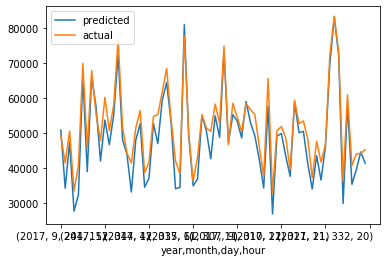

In [619]:
compare.head(70).plot()

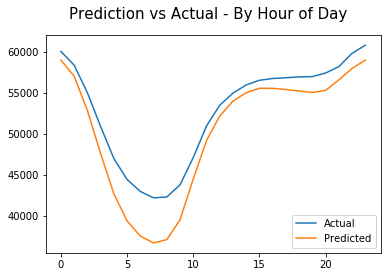

In [620]:
# Find hourly average 
predicted_hourly = compare['predicted'].groupby( ['hour'] ).mean().reset_index()
actual_hourly = compare['actual'].groupby(['hour']).mean().reset_index()

plt.suptitle('Prediction vs Actual - By Hour of Day', fontsize=15)
plt.plot(actual_hourly['actual'], label='Actual')
plt.plot(predicted_hourly['predicted'], label='Predicted')
plt.legend()

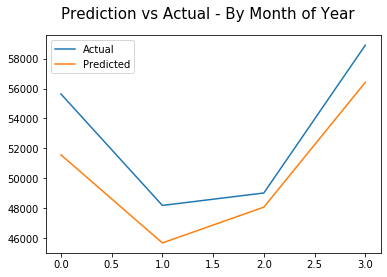

In [621]:
# Find monthly average 
predicted_monthly = compare['predicted'].groupby( ['month'] ).mean().reset_index()
actual_monthly = compare['actual'].groupby(['month']).mean().reset_index()

plt.suptitle('Prediction vs Actual - By Month of Year', fontsize=15)
plt.plot(actual_monthly['actual'], label='Actual')
plt.plot(predicted_monthly['predicted'], label='Predicted')
plt.legend()

### Merge to create demand data for Simple Dispatch

Get Actual Gen for Simple Dispatch

In [733]:
actual_gen.reset_index(inplace=True)

In [735]:
actual_gen['datetime'] = pd.to_datetime(actual_gen['year'] * 1000 + actual_gen['day'], format='%Y%j') + pd.to_timedelta(actual_gen.hour, unit='h')


In [752]:
actual_gen_2016 = actual_gen.loc[actual_gen['year'] == 2016]
actual_gen_2016 = actual_gen_2016[['datetime', 'mw']]
actual_gen_2016.columns = ['datetime', 'demand']
actual_gen_2016.to_csv('2016_PJMdemand_date_actual.csv')

In [753]:
actual_gen_2017 = actual_gen.loc[actual_gen['year'] == 2017]
actual_gen_2017 = actual_gen_2017[['datetime', 'mw']]
actual_gen_2017.columns = ['datetime', 'demand']
actual_gen_2017.to_csv('2017_PJMdemand_date_actual.csv')

In [754]:
actual_gen_2017

,datetime,demand
8752,2017-01-01 05:00:00,44830.3
8753,2017-01-01 06:00:00,43808.4
8754,2017-01-01 07:00:00,42352.6
8755,2017-01-01 08:00:00,41673.1
8756,2017-01-01 09:00:00,41688.0
...,...,...
17384,2017-12-31 19:00:00,74816.1
17385,2017-12-31 20:00:00,74675.1
17386,2017-12-31 21:00:00,75646.0
17387,2017-12-31 22:00:00,80477.5


Compare Actual and Predicted

In [622]:
compare.sort_index(inplace=True)
compare.reset_index(inplace=True)

In [624]:
compare['datetime'] = pd.to_datetime(compare['year'] * 1000 + compare['day'], format='%Y%j') + pd.to_timedelta(compare.hour, unit='h')

In [704]:
compare

,year,month,day,hour,predicted,actual,datetime
0,2017,9,244,0,64014.250867,63622.2,2017-09-01 00:00:00
1,2017,9,244,1,60549.354067,61477.4,2017-09-01 01:00:00
2,2017,9,244,2,53069.027167,56561.1,2017-09-01 02:00:00
3,2017,9,244,3,45503.921167,48920.4,2017-09-01 03:00:00
4,2017,9,244,4,37950.054667,43723.0,2017-09-01 04:00:00
...,...,...,...,...,...,...,...
2899,2017,12,364,19,63750.034244,67848.6,2017-12-30 19:00:00
2900,2017,12,364,20,63969.634844,69044.3,2017-12-30 20:00:00
2901,2017,12,364,21,66650.372544,69437.0,2017-12-30 21:00:00
2902,2017,12,364,22,70595.960544,73180.1,2017-12-30 22:00:00


In [626]:
# Save actual demand values to csv to run in simple dispatch for the "true" values 
actual_fossil_gen = compare[['datetime', 'actual']]
actual_fossil_gen.to_csv('2017_PJMdemand_date_actual.csv')

In [637]:
actual_fossil_gen

,datetime,actual
0,2017-09-01 00:00:00,63622.2
1,2017-09-01 01:00:00,61477.4
2,2017-09-01 02:00:00,56561.1
3,2017-09-01 03:00:00,48920.4
4,2017-09-01 04:00:00,43723.0
...,...,...
2899,2017-12-30 19:00:00,67848.6
2900,2017-12-30 20:00:00,69044.3
2901,2017-12-30 21:00:00,69437.0
2902,2017-12-30 22:00:00,73180.1


In [648]:
predicted = compare[['datetime', 'predicted']]

In [633]:
actual_demand = pd.read_csv('2017_PJMdemand_data.csv', parse_dates = ['datetime'], usecols = [1, 2])

In [692]:
actual_demand_train = actual_demand.loc['2017-01-01':'2017-08-31']


In [697]:
actual_demand_train

,demand
datetime,
2017-01-01 00:00:00,43182.0
2017-01-01 01:00:00,42377.0
2017-01-01 02:00:00,41416.0
2017-01-01 03:00:00,41075.0
2017-01-01 04:00:00,41070.0
...,...
2017-08-31 19:00:00,59950.0
2017-08-31 20:00:00,58347.0
2017-08-31 21:00:00,52987.0


In [645]:
merged = predicted.merge(actual_demand, how='inner', on=['datetime'])

In [699]:
merged = merged[['predicted']]
merged.columns = ['demand']

In [700]:
merged

,demand
datetime,
2017-09-01 00:00:00,64014.250867
2017-09-01 01:00:00,60549.354067
2017-09-01 02:00:00,53069.027167
2017-09-01 03:00:00,45503.921167
2017-09-01 04:00:00,37950.054667
...,...
2017-12-30 19:00:00,63750.034244
2017-12-30 20:00:00,63969.634844
2017-12-30 21:00:00,66650.372544


In [702]:
# append the two dataframes 
demand_for_dispatch = pd.concat([actual_demand_train, merged]).dropna()


In [703]:
demand_for_dispatch.to_csv('2017_PJMdemand_data_with_pred.csv')

### Error

In [706]:
compare = compare[['datetime', 'predicted', 'actual']]

In [708]:
compare['error'] = (compare['actual'] - compare['predicted'])**2

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [710]:
# Standardize the Error 
a, b = 0, 1
x, y = compare.error.min(), compare.error.max()
compare['error_standardized'] = (compare.error - x) / (y - x) * (b - a) + a

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [711]:
compare

,datetime,predicted,actual,error,error_standardized
0,2017-09-01 00:00:00,64014.250867,63622.2,1.537039e+05,0.001110
1,2017-09-01 01:00:00,60549.354067,61477.4,8.612693e+05,0.006221
2,2017-09-01 02:00:00,53069.027167,56561.1,1.219457e+07,0.088083
3,2017-09-01 03:00:00,45503.921167,48920.4,1.167233e+07,0.084311
4,2017-09-01 04:00:00,37950.054667,43723.0,3.332690e+07,0.240724
...,...,...,...,...,...
2899,2017-12-30 19:00:00,63750.034244,67848.6,1.679824e+07,0.121336
2900,2017-12-30 20:00:00,63969.634844,69044.3,2.575223e+07,0.186011
2901,2017-12-30 21:00:00,66650.372544,69437.0,7.765293e+06,0.056090
2902,2017-12-30 22:00:00,70595.960544,73180.1,6.677777e+06,0.048234


In [712]:
compare.error_standardized

,datetime,predicted,actual,error,error_standardized
0,2017-09-01 00:00:00,64014.250867,63622.2,1.537039e+05,0.001110
1,2017-09-01 01:00:00,60549.354067,61477.4,8.612693e+05,0.006221
2,2017-09-01 02:00:00,53069.027167,56561.1,1.219457e+07,0.088083
3,2017-09-01 03:00:00,45503.921167,48920.4,1.167233e+07,0.084311
4,2017-09-01 04:00:00,37950.054667,43723.0,3.332690e+07,0.240724
...,...,...,...,...,...
2899,2017-12-30 19:00:00,63750.034244,67848.6,1.679824e+07,0.121336
2900,2017-12-30 20:00:00,63969.634844,69044.3,2.575223e+07,0.186011
2901,2017-12-30 21:00:00,66650.372544,69437.0,7.765293e+06,0.056090
2902,2017-12-30 22:00:00,70595.960544,73180.1,6.677777e+06,0.048234


In [726]:
low_error_dates = compare.loc[compare['error_standardized'] < 0.00001]

In [727]:
low_error_dates = extract_date(low_error_dates, 'datetime')

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [728]:
low_error_dates = low_error_dates[['year', 'day', 'month', 'hour', 'actual']]

In [724]:
low_error_dates.to_csv("simple_dispatch_low_error.csv")

In [729]:
low_error_dates

,year,day,month,hour,actual
21,2017,244,9,21,49073.6
115,2017,248,9,19,67000.2
596,2017,268,9,20,96957.5
597,2017,268,9,21,95995.6
689,2017,272,9,17,54776.3
1078,2017,288,10,22,49266.3
1096,2017,289,10,16,52455.4
1294,2017,297,10,22,50119.6
1356,2017,300,10,12,51121.6
1507,2017,306,11,19,51140.6
